In [72]:
import pandas as pd
from DeGiroWrapper import DeGiroWrapper
from Utils import process_price_history, analytics
DGW = DeGiroWrapper()

JSONDecodeError: [Errno Expecting value] <!DOCTYPE html>
<html lang="nl">
<head>

        <!-- Google Tag Manager -->
<script>(function(w,d,s,l,i){w[l]=w[l]||[];w[l].push({'gtm.start':
new Date().getTime(),event:'gtm.js'});var f=d.getElementsByTagName(s)[0],
j=d.createElement(s),dl=l!='dataLayer'?'&l='+l:'';j.async=true;j.src=
'//www.googletagmanager.com/gtm.js?id='+i+dl;f.parentNode.insertBefore(j,f);
})(window,document,'script','dataLayer','GTM-MW7JKT');</script>
<!-- End Google Tag Manager -->
<script>
hj('trigger', 'homepage');
</script>
    
<!-- Required meta tags -->
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no">
    <link rel="shortcut icon" href="assets/images/favicon.ico">
    <link rel="apple-touch-icon" href="assets/images/icon-iphone.png">
    <link rel="apple-touch-icon" sizes="72x72" href="assets/images/icon-ipad.png">
    <link rel="apple-touch-icon" sizes="114x114" href="assets/images/icon-iphone4.png">

    <base href="https://www.degiro.nl/">

    <link rel="canonical" href="https://www.degiro.nl/" />
    

    <title>Maintenance</title>
    <meta name="description" content="" />
    <meta name="google-site-verification" content="ExHvPZmroOxAQF4N7Yi8wFRzvdJEyjGjiPB78idQekY" />

    <!-- Bootstrap CSS -->
    <link rel="stylesheet" href="/assets/dg-2017/css/bootstrap.min.css">
    <link rel="stylesheet" href="/assets/dg-2017/css/font-awesome.min.css">
    <link rel="stylesheet" href="/assets/dg-2017/css/aos.css">
    <link rel="stylesheet" href="/assets/dg-2017/bxslider/jquery.bxslider.min.css">
    <link rel="stylesheet" href="/assets/dg-2017/css/custom.min.css?v=274">
    <link rel="stylesheet" href="/assets/dg-2017/css/main-nl.css?v=285">

    <script>
(function (i, s, o, g, r, a, m) {
    i['GoogleAnalyticsObject'] = r;
    i[r] = i[r] || function () {
        (i[r].q = i[r].q || []).push(arguments)
    }, i[r].l = 1 * new Date();
    a = s.createElement(o),
            m = s.getElementsByTagName(o)[0];
    a.async = 1;
    a.src = g;
    m.parentNode.insertBefore(a, m)
})(window, document, 'script', '//www.google-analytics.com/analytics.js', 'ga');
ga('create', 'UA-29259433-1', 'auto', {'allowLinker': true});
ga('require', 'linker');
ga('linker:autoLink', ['www.degiro.nl', 'www.degiro.be', 'www.degiro.fr', 'www.degiro.at', 'www.degiro.cz', 'www.degiro.pl', 'www.degiro.es', 'www.degiro.de', 'www.degiro.hu', 'www.degiro.gr', 'www.degiro.cz', 'www.degiro.it', 'www.degiro.dk', 'www.degiro.co.no', 'www.degiro.pt', 'www.degiro.co.uk', 'www.degiro.fi', 'www.degiro.ie', 'www.degiro.eu', 'www.degiro.ch', 'www.degiro.se']);
ga('require', 'linkid', 'linkid.js');
ga('require', 'displayfeatures');
ga('send', 'pageview');
</script>

    <script>
/**
* Function that tracks a click on an outbound link in Analytics.
* This function takes a valid URL string as an argument, and uses that URL string
* as the event label. Setting the transport method to 'beacon' lets the hit be sent
* using 'navigator.sendBeacon' in browser that support it.
*/
var trackOutboundLink = function(url, category) {
   ga('send', 'event', category, 'click', url, {
     'transport': 'beacon',
     'hitCallback': function(){document.location = url;}
   });
}
</script>
   
</head>

<body>
<noscript><iframe src="//www.googletagmanager.com/ns.html?id=GTM-MW7JKT"
height="0" width="0" style="display:none;visibility:hidden"></iframe></noscript>




<div id="under-construction">

    <!--
    <div class="container-fluid cookie-policy hide bg-brand-dark white min-h-40">
        <div id="cookie-notification" class="row justify-content-center align-items-center roboto-reg-12 p4">
            <span>Deze website maakt gebruik van cookies.</span>

            <a href="#" id="cookie-consent-top" class="d-inline-block ml-2">
                <span class="close-btn white"></span>
            </a>
        </div>
    </div> -->

 <!-- ============================= Header ============================= -->
    <div class="container-fluid border-bottom height-header bg-white z-10 fixed-top mt-40" id="header-menu">
        <div class="container">
            <div class="row">
                <div class="col-12">

                    <nav class="navbar navbar-toggleable justify-content-between navbar-light w-100">

                        <!-- Logo -->
                        <div class="logo">
                            <a class="navbar-brand" href="https://www.degiro.nl"><img src="/assets/dg-2017/imgs/logo-degiro-2018.svg" alt="Online broker DEGIRO"></a>
                        </div>

                        <!-- Horizontal Nav -->
                        <div class="screen-nav top-navbar">
                            <ul class="navbar-nav roboto-med-14" >

</ul>
                        </div>

                        <div class="float-right">
                            <!-- Mobile toggler btn -->

                            <!-- Open Acc & Login btns -->

                        </div>
                    </nav>

                </div> <!-- end: col-12-->
            </div>
        </div>

        <div class="row p-0">
            <div class="col-12 p-0">
                <!-- Vertical Mob Nav -->
                <div class="mobile-nav top-navbar">
                    <div class="clearfix">
                        <div class="mobile-toggler float-right pr-4" style="display: none;">
                            <span class="fa fa-close"></span>
                        </div>
                    </div>

                    <ul class="navbar-nav mr-auto roboto-med-14" >
</ul>
                    
                </div>

            </div>
        </div>
   
 </div>


<!-- ============================= Content under construnction ============================= -->
    <div id="under-const-content" class="d-flex construct-content justify-content-center align-items-center align-content-center">
        <div class="max-w-640">
            <img class="maintenance m-auto" src="assets/dg-2017/imgs/maintenance.png" alt="">
            <h1 class="alte-24 font-weight-bold mt-60 mb-20 text-center">
      		Scheduled maintenance this weekend
            </h1>
            <p class="roboto-reg-14 grey text-center">
		Due to periodic maintenance, the platform will temporarily be unavailable between Saturday, 27 August 2022, 14:00 CET, and Sunday, 28 August 2022, 15:00 CET. It will not be possible to log in to your DEGIRO account during this time. Please note that exchanges are also closed during the said maintenance period, limiting the impact. Our apologies for any inconvenience caused.
            </p>
        </div>
    </div>



    <div class="container-fluid cookie-policy-bottom hide bg-brand-dark white min-h-40">
        <div id="cookie-notification" class="row justify-content-center align-items-center roboto-reg-12 p4">

            <span class="hidden-sm-down">Om degiro.nl goed te laten functioneren, worden er cookies gebruikt. In ons <a href="privacy-cookies.html" title="Privacy & Cookies">privacystatement</a> leest u wat dit voor u betekent.</span>


            <a href="#" id="cookie-consent" class="d-inline-block ml-2">
                <span class="close-btn white"></span>
            </a>
        </div>
    </div>    




<div id="footer-scripts">
<script type="text/javascript" src="//www.googleadservices.com/pagead/conversion.js">
</script>
</div>
<script type="text/javascript">
setTimeout(function(){var a=document.createElement("script");
var b=document.getElementsByTagName("script")[0];
a.src=document.location.protocol+"//dnn506yrbagrg.cloudfront.net/pages/scripts/0018/7245.js?"+Math.floor(new Date().getTime()/3600000);
a.async=true;a.type="text/javascript";b.parentNode.insertBefore(a,b)}, 1);
</script>

<!-- Google Code for Remaketing 7 dagen -->
<!-- Remarketing tags may not be associated with personally identifiable information or placed on pages related to sensitive categories. For instructions on adding this tag and more information on the above requirements, read the setup guide: google.com/ads/remarketingsetup -->
<script type="text/javascript">
/* <![CDATA[ */
var google_conversion_id = 991581952;
var google_conversion_label = "T_lTCJj1gQcQgK7p2AM";
var google_custom_params = window.google_tag_params;
var google_remarketing_only = true;
/* ]]> */
</script>
<noscript>
<div>
<img height="1" width="1" alt="" src="//googleads.g.doubleclick.net/pagead/viewthroughconversion/991581952/?value=0&amp;label=T_lTCJj1gQcQgK7p2AM&amp;guid=ON&amp;script=0"/>
</div>
</noscript>
<!--Javascript-->
<script type="text/javascript" src="/assets/dg-2017/js/jquery3.2.1.min.js"></script>
<script type="text/javascript" src="/assets/dg-2017/js/utils.js"></script>
<script type="text/javascript" src="/assets/dg-2017/js/tether.min.js"></script>
<script type="text/javascript" src="/assets/dg-2017/js/bootstrap.min.js"></script>
<script type="text/javascript" src="/assets/dg-2017/js/aos.js"></script>
<script type="text/javascript" src="/assets/dg-2017/js/custom.min.js?v32"></script>
<script type="text/javascript" src="/assets/dg-2017/js/custom-page-nl.min.js?v36"></script>

<script type="text/javascript" src="/assets/dg-2017/js/Chart.bundle.js"></script>
<script type="text/javascript" src="/assets/dg-2017/js/Charts.utils.min.js?v=1"></script>
<script type="text/javascript" src="/assets/dg-2017/js/calculator-chart-functions-nl.min.js?v50"></script>


</body>
</html>
: 0

In [ ]:
pf = DGW.get_portfolio()

In [16]:
P = []
for id, vwid in pf.iterrows():
    if vwid.vwids is None: continue
    out = DGW.get_price_history(vwid=vwid.vwids, history='50Y', resolution='1M')
    prices = process_price_history(out).price.rename(vwid['Product'])
    P.append(prices)
P = pd.concat(P, axis=1)

In [28]:
df =DGW.get_overview('01/01/2020')

In [39]:
df.balance.iloc[0]['cashFund']

[{'participation': 0.0, 'price': 9801.3685, 'id': 15694501}]

In [46]:
df.head(30)

,date,valueDate,id,description,currency,balance,type,productId,change,orderId,exchangeRate
0,2022-08-02T11:03:50+02:00,2022-08-01T23:59:59+02:00,1.452449e+09,Overboeking van uw geldrekening bij flatexDEGI...,EUR,"{'cashFund': [{'participation': 0.0, 'price': ...",FLATEX_CASH_SWEEP,NaN,NaN,NaN,NaN
1,2022-08-02T11:03:50+02:00,2022-08-01T23:59:59+02:00,1.452449e+09,Degiro Cash Sweep Transfer,EUR,"{'cashFund': [{'participation': 0.0, 'price': ...",FLATEX_CASH_SWEEP,17707507.0,2.500,NaN,NaN
2,2022-08-01T17:50:06+02:00,2022-07-31T23:59:59+02:00,1.451602e+09,Giro Exchange Connection Fee 2022,EUR,"{'cashFund': [{'participation': 0.0, 'price': ...",CASH_TRANSACTION,NaN,-2.500,NaN,NaN
3,2022-07-28T16:48:09+02:00,2022-07-28T16:48:09+02:00,1.448769e+09,Overboeking naar uw geldrekening bij flatexDEG...,EUR,"{'cashFund': [{'participation': 0.0, 'price': ...",FLATEX_CASH_SWEEP,NaN,NaN,NaN,NaN
4,2022-07-28T16:48:09+02:00,2022-07-28T16:48:09+02:00,1.448769e+09,Degiro Cash Sweep Transfer,EUR,"{'cashFund': [{'participation': 0.0, 'price': ...",FLATEX_CASH_SWEEP,17707507.0,-4.350,NaN,NaN
5,2022-07-28T08:14:00+02:00,2022-07-27T23:59:59+02:00,1.448045e+09,Dividend,EUR,"{'cashFund': [{'participation': 0.0, 'price': ...",CASH_TRANSACTION,837817.0,4.350,NaN,NaN
6,2022-07-13T16:47:41+02:00,2022-07-13T16:47:41+02:00,1.437955e+09,Overboeking van uw geldrekening bij flatexDEGI...,EUR,"{'cashFund': [{'participation': 0.0, 'price': ...",FLATEX_CASH_SWEEP,NaN,NaN,NaN,NaN
7,2022-07-13T16:47:41+02:00,2022-07-13T16:47:41+02:00,1.437955e+09,Degiro Cash Sweep Transfer,EUR,"{'cashFund': [{'participation': 0.0, 'price': ...",FLATEX_CASH_SWEEP,17707507.0,12981.010,NaN,NaN
8,2022-07-13T09:40:48+02:00,2022-07-12T23:59:59+02:00,1.437590e+09,iDEAL Deposit,EUR,"{'cashFund': [{'participation': 0.0, 'price': ...",CASH_TRANSACTION,NaN,13000.000,NaN,NaN
9,2022-07-13T09:40:48+02:00,2022-07-12T23:59:59+02:00,1.437590e+09,Reservation iDEAL / Sofort Deposit,EUR,"{'cashFund': [{'participation': 0.0, 'price': ...",CASH_TRANSACTION,NaN,-13000.000,NaN,NaN


In [69]:
df.balance.iloc[4]

{'cashFund': [{'participation': 0.0, 'price': 9801.6549, 'id': 15694501}],
 'unsettledCash': -0.0032797553,
 'flatexCash': 18.99,
 'total': 18.9867202447}

In [68]:
df.iloc[4]

date                                    2022-07-28T16:48:09+02:00
valueDate                               2022-07-28T16:48:09+02:00
id                                                   1448768627.0
description                            Degiro Cash Sweep Transfer
currency                                                      EUR
balance         {'cashFund': [{'participation': 0.0, 'price': ...
type                                            FLATEX_CASH_SWEEP
productId                                              17707507.0
change                                                      -4.35
orderId                                                       NaN
exchangeRate                                                  NaN
Name: 4, dtype: object

In [30]:
df.type.unique()

array(['FLATEX_CASH_SWEEP', 'CASH_TRANSACTION', 'TRANSACTION', 'PAYMENT',
       'CASH_FUND_TRANSACTION'], dtype=object)

In [24]:
pf[['Product', 'weight']].set_index('Product').weight

Product
CASH & CASH FUND & FTX CASH (EUR)     0.001386
ISHARES $ TIPS UCITS ETF              0.322206
ISHARES B E CORP                      0.063505
ISHARES E INF-LINK                    0.154970
ISHARES HEALTHCARE INNOVATION U...    0.006065
ISHARES MSCI AUSTRALIA UCITS ET...    0.051568
ISHARES S&P 500 INF TECH SECTOR...    0.003639
ISHARES STOXX EUROPE 600 UCITS ...    0.100433
VANECK VECTORS ETHEREUM ETN           0.006153
VANGUARD S&P500                       0.290075
Name: weight, dtype: float64

In [22]:
P

,ISHARES $ TIPS UCITS ETF,ISHARES B E CORP,ISHARES E INF-LINK,ISHARES HEALTHCARE INNOVATION U...,ISHARES MSCI AUSTRALIA UCITS ET...,ISHARES S&P 500 INF TECH SECTOR...,ISHARES STOXX EUROPE 600 UCITS ...,VANECK VECTORS ETHEREUM ETN,VANGUARD S&P500
date,,,,,,,,,
2005-11-01,NaN,NaN,158.70,NaN,NaN,NaN,NaN,NaN,NaN
2005-12-01,NaN,NaN,161.00,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-01,NaN,NaN,159.20,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-01,NaN,NaN,159.00,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-01,NaN,NaN,156.10,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-04-01,246.65,122.87,240.74,7.051,43.470,17.274,44.845,16.3760,76.041
2022-05-01,242.27,121.54,231.74,6.647,42.130,16.352,44.510,10.9800,72.998
2022-06-01,235.40,117.35,224.51,6.765,38.145,15.218,40.415,5.9445,68.541


In [18]:
P.apply(lambda x: pd.Series(analytics(x.dropna())))

,ISHARES $ TIPS UCITS ETF,ISHARES B E CORP,ISHARES E INF-LINK,ISHARES HEALTHCARE INNOVATION U...,ISHARES MSCI AUSTRALIA UCITS ET...,ISHARES S&P 500 INF TECH SECTOR...,ISHARES STOXX EUROPE 600 UCITS ...,VANECK VECTORS ETHEREUM ETN,VANGUARD S&P500
Mean return,0.034359,0.009203,0.024456,0.105036,0.085982,0.224702,0.028862,0.592955,0.143514
Std,0.063528,0.045490,0.055106,0.179819,0.179028,0.184350,0.153083,1.111783,0.140641
Adjusted Return,0.540845,0.202305,0.443810,0.584119,0.480268,1.218892,0.188539,0.533337,1.020425
NumDD,15.000000,12.000000,24.000000,9.000000,11.000000,14.000000,8.000000,3.000000,17.000000
MaxDD,0.119984,0.140041,0.100481,0.259635,0.300461,0.222143,0.571498,0.762410,0.180388
Max DD duration,78.000000,34.000000,26.000000,20.000000,26.000000,14.000000,153.000000,11.000000,18.000000
Mean DD duration,11.333333,13.333333,8.416667,8.000000,8.545455,5.785714,24.500000,6.000000,6.529412
T,170.000000,160.000000,202.000000,72.000000,94.000000,81.000000,196.000000,18.000000,111.000000


<AxesSubplot:xlabel='date'>

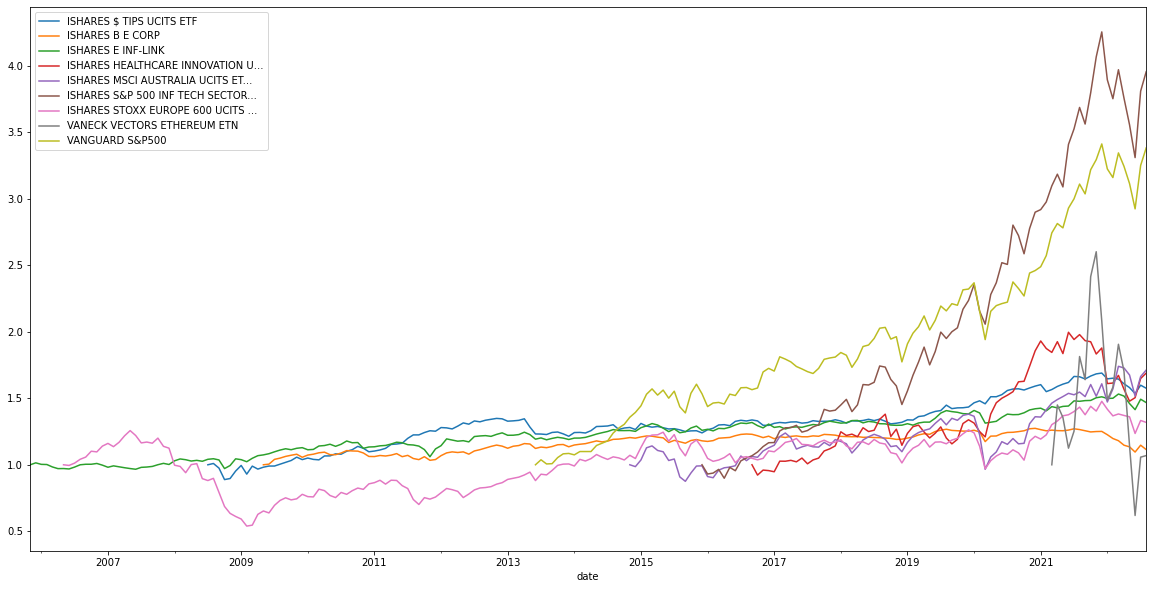

In [17]:
P.apply(lambda x: x.divide(x.dropna().iloc[0])).plot(figsize=(20,10))

In [20]:
vwid['vwids']

In [2]:
out = DGW.get_price_history('IE00B1FZSC47',
                            history='50Y',
                            resolution='1M')

In [3]:
prices = process_price_history(out)
out = analytics(prices)

In [4]:
out

{'Mean return': 0.03435854599672029,
 'Std': 0.06352754781824453,
 'Adjusted Return': 0.5408448330954281,
 'NumDD': 15,
 'MaxDD': 0.1199844931188216,
 'Max DD duration': 78,
 'Mean DD duration': 11.333333333333334,
 'T': 170}